In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_SHOW_CPP_STACKTRACES"] = "1"

In [2]:
import sys, copy, math, json, time, joblib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from MOE_multimodal_model_classes import *
from MOE_quick_cls_heads import *
from MOE_training import *
from diagnostics import *
from MOE_configs import *
from multimodal_data_processing import *

current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")

# Add the parent directory folder to the system path
sys.path.append(os.path.abspath(os.path.join('..')))
print(f"CWD after sys path append: {os.getcwd()}")

from configs.hyperparam_tuned_configs import *
from utils.DNN_FT_funcs import *
from utils.gesture_dataset_classes import *

from utils.global_seed import set_seed
set_seed()

timestamp = datetime.now().strftime("%Y%m%d_%H%M")



The current working directory is: c:\Users\kdmen\Repos\fl-gestures\April_25\MOE
CWD after sys path append: c:\Users\kdmen\Repos\fl-gestures\April_25\MOE
DNN_FT_funcs.py: The current working directory is: c:\Users\kdmen\Repos\fl-gestures\April_25\MOE
Global seed set to 17


In [3]:
print("Loading")
start_time = time.time()
data_df = pd.read_pickle('C:\\Users\\kdmen\\Box\\Yamagami Lab\\Data\\Meta_Gesture_Project\\filtered_datasets\\metadata_IMU_EMG_allgestures_allusers.pkl')
end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 5.400001764297485s


In [4]:
print(data_df.shape)
data_df.head()

(204800, 91)


,Participant,Gesture_ID,Gesture_Num,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.341797,-0.939941,0.000977,-0.007450,-0.192625,0.005321,-0.380859,...,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,P102,pan,1,0.336178,-0.963185,0.003898,0.009595,-0.190446,-0.026116,-0.394547,...,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,P102,pan,1,0.353539,-0.963704,0.011711,0.095966,-0.205480,-0.155563,-0.398406,...,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,P102,pan,1,0.352841,-0.950288,0.011509,0.058836,-0.184871,-0.083567,-0.389230,...,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,P102,pan,1,0.372621,-0.991273,0.029847,0.293946,-0.178756,-0.281361,-0.396043,...,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


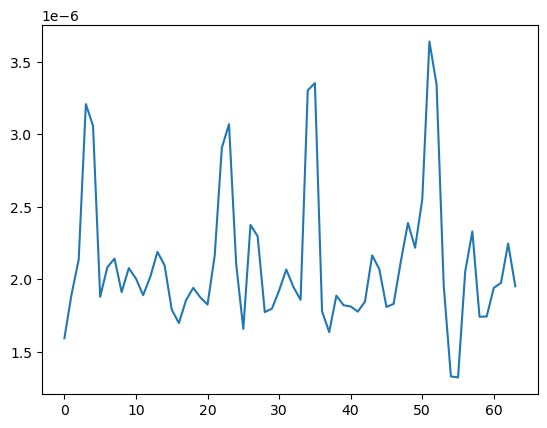

In [5]:
plt.plot(data_df.iloc[:64, 90])

In [6]:
metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
metadata_cols_df = data_df[metadata_cols]
metadata_cols_df = metadata_cols_df.rename(columns={"Participant": "PID"})
# Convert 'Gesture_Num' to integers
metadata_cols_df['Gesture_Num'] = metadata_cols_df['Gesture_Num'].astype(int)

print(metadata_cols_df.shape)
metadata_cols_df.head()

(204800, 3)


,PID,Gesture_ID,Gesture_Num
0,P102,pan,1
1,P102,pan,1
2,P102,pan,1
3,P102,pan,1
4,P102,pan,1


In [7]:
X_df = data_df.drop(metadata_cols, axis=1)

print(X_df.shape)
X_df.head()

(204800, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,0.341797,-0.939941,0.000977,-0.007450,-0.192625,0.005321,-0.380859,-0.888184,-0.334961,0.124514,...,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,0.336178,-0.963185,0.003898,0.009595,-0.190446,-0.026116,-0.394547,-0.905297,-0.344967,0.144735,...,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,0.353539,-0.963704,0.011711,0.095966,-0.205480,-0.155563,-0.398406,-0.905250,-0.343246,0.140630,...,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,0.352841,-0.950288,0.011509,0.058836,-0.184871,-0.083567,-0.389230,-0.896252,-0.337100,0.185074,...,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,0.372621,-0.991273,0.029847,0.293946,-0.178756,-0.281361,-0.396043,-0.903902,-0.343370,0.189500,...,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


In [8]:
all_PIDs = metadata_cols_df['PID']
unique_PIDs = all_PIDs.unique()

print(f"{len(unique_PIDs)} Unique PIDs!")
print(unique_PIDs)

PID_encoder = LabelEncoder()
PID_encoder.fit(unique_PIDs)  # Fit on full list

32 Unique PIDs!
['P102' 'P103' 'P104' 'P105' 'P106' 'P107' 'P108' 'P109' 'P110' 'P111'
 'P112' 'P114' 'P115' 'P116' 'P118' 'P119' 'P121' 'P122' 'P123' 'P124'
 'P125' 'P126' 'P127' 'P128' 'P131' 'P132' 'P004' 'P005' 'P006' 'P008'
 'P010' 'P011']


LabelEncoder()

In [9]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
gesture_ID_label_encoder = LabelEncoder()
# Fit and transform the Gesture_ID column
metadata_cols_df['Enc_Gesture_ID'] = gesture_ID_label_encoder.fit_transform(metadata_cols_df['Gesture_ID'])
# Optional: If you want to see the mapping
label_mapping = dict(zip(gesture_ID_label_encoder.classes_, gesture_ID_label_encoder.transform(gesture_ID_label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Now transform the actual PID column in your DataFrame
metadata_cols_df['Enc_PID'] = PID_encoder.transform(metadata_cols_df['PID'])

print()
print(metadata_cols_df.shape)
metadata_cols_df.head()

Label Mapping: {'close': 0, 'delete': 1, 'duplicate': 2, 'move': 3, 'open': 4, 'pan': 5, 'rotate': 6, 'select-single': 7, 'zoom-in': 8, 'zoom-out': 9}

(204800, 5)


,PID,Gesture_ID,Gesture_Num,Enc_Gesture_ID,Enc_PID
0,P102,pan,1,5,6
1,P102,pan,1,5,6
2,P102,pan,1,5,6
3,P102,pan,1,5,6
4,P102,pan,1,5,6


In [10]:
ppd_B_X_df = preprocess_df_B_by_gesture(X_df)

In [11]:
print(ppd_B_X_df.shape)
ppd_B_X_df.head()

(204800, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.551109,-0.738972,-0.985439,0.181924,0.059616,0.087024,1.055804,-0.883268,-0.327978,-0.221822,...,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,-0.571115,-0.821726,-0.975036,0.242607,0.067375,-0.024900,1.007074,-0.944195,-0.363602,-0.149833,...,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,-0.509305,-0.823575,-0.947221,0.550111,0.013848,-0.485765,0.993332,-0.944029,-0.357476,-0.164447,...,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,-0.511788,-0.775810,-0.947939,0.417919,0.087222,-0.229441,1.026003,-0.911993,-0.335594,-0.006214,...,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,-0.441369,-0.921726,-0.882652,1.254970,0.108993,-0.933639,1.001748,-0.939228,-0.357917,0.009543,...,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [12]:
ppd_B_X_df.columns

Index(['IMU1_ax', 'IMU1_ay', 'IMU1_az', 'IMU1_vx', 'IMU1_vy', 'IMU1_vz',
       'IMU2_ax', 'IMU2_ay', 'IMU2_az', 'IMU2_vx', 'IMU2_vy', 'IMU2_vz',
       'IMU3_ax', 'IMU3_ay', 'IMU3_az', 'IMU3_vx', 'IMU3_vy', 'IMU3_vz',
       'IMU4_ax', 'IMU4_ay', 'IMU4_az', 'IMU4_vx', 'IMU4_vy', 'IMU4_vz',
       'IMU5_ax', 'IMU5_ay', 'IMU5_az', 'IMU5_vx', 'IMU5_vy', 'IMU5_vz',
       'IMU6_ax', 'IMU6_ay', 'IMU6_az', 'IMU6_vx', 'IMU6_vy', 'IMU6_vz',
       'IMU7_ax', 'IMU7_ay', 'IMU7_az', 'IMU7_vx', 'IMU7_vy', 'IMU7_vz',
       'IMU8_ax', 'IMU8_ay', 'IMU8_az', 'IMU8_vx', 'IMU8_vy', 'IMU8_vz',
       'IMU9_ax', 'IMU9_ay', 'IMU9_az', 'IMU9_vx', 'IMU9_vy', 'IMU9_vz',
       'IMU11_ax', 'IMU11_ay', 'IMU11_az', 'IMU11_vx', 'IMU11_vy', 'IMU11_vz',
       'IMU13_ax', 'IMU13_ay', 'IMU13_az', 'IMU13_vx', 'IMU13_vy', 'IMU13_vz',
       'IMU15_ax', 'IMU15_ay', 'IMU15_az', 'IMU15_vx', 'IMU15_vy', 'IMU15_vz',
       'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG9',
       'EMG10', 'EMG11', 'E

## Load In Demographics Data
> xlsx for users with disabilities

In [13]:
import pandas as pd

pwmd_xlsx_filepath = "C:\\Users\\kdmen\\Repos\\fl-gestures\\Biosignal gesture questionnaire for participants with disabilities.xlsx"

FULL_pwmd_demo_df = pd.read_excel(pwmd_xlsx_filepath)
print(f"Shape: {FULL_pwmd_demo_df.shape}")


Shape: (34, 48)


In [14]:
# Select the meaningful columns
# Also, drop the bottom 7 rows, since they contain average inforamtion / notes (ie they are not participant rows)
pwmd_demo_df = FULL_pwmd_demo_df[["PID", "disability coding", "time disabled", "Actual handedness", "What is your age?", "What is your gender?", "BMI", "DASH score"]][:-8]  
pwmd_demo_df["time disabled"] = pd.to_numeric(pwmd_demo_df["time disabled"].astype(str).str.strip(), errors='coerce')  # Ensure that time disabled is float, instead of dtype=object or string
print(pwmd_demo_df.shape)
#pwmd_demo_df.head()

(26, 8)


In [15]:
numeric_df = pwmd_demo_df.select_dtypes(include='number')
print("Min values:\n", numeric_df.min())
print("\nMax values:\n", numeric_df.max())



Min values:
 time disabled         2.0
What is your age?    22.0
DASH score           14.0
dtype: float64

Max values:
 time disabled        52.0
What is your age?    77.0
DASH score           82.0
dtype: float64


In [16]:
# Select only numeric columns
numeric_cols = pwmd_demo_df.select_dtypes(include='number').columns

# Divide each numeric column by 100 (I use 100 to be more general, in principle the age could be 0-100 and the DASH Score seems to also be 0-100)
pwmd_demo_df[numeric_cols] = pwmd_demo_df[numeric_cols] / 100.0

pwmd_demo_df["BMI"] = pwmd_demo_df["BMI"] / 70.0  # Assuming 70 is a reasonable population upper bound

pwmd_demo_df['Enc_PID'] = PID_encoder.transform(pwmd_demo_df["PID"])



> xlsx for users without disabilities

In [17]:
pwoutmd_xlsx_filepath = "C:\\Users\\kdmen\\Repos\\fl-gestures\\Biosignal gesture questionnaire for participants without disabilities.xlsx"

FULL_pwoutmd_demo_df = pd.read_excel(pwoutmd_xlsx_filepath)
print(f"Shape: {FULL_pwoutmd_demo_df.shape}")

Shape: (13, 21)


In [18]:
# Select the meaningful columns
# Also, drop the bottom 5 rows, since they contain average inforamtion / notes (ie they are not participant rows)
pwoutmd_demo_df = FULL_pwoutmd_demo_df[["PID", "disability coding", "time disabled", "Actual handedness", "What is your age?", "What is your gender?", "BMI", "DASH score"]][:-5]  
pwoutmd_demo_df["time disabled"] = pd.to_numeric(pwoutmd_demo_df["time disabled"].astype(str).str.strip(), errors='coerce')  # Ensure that time disabled is float, instead of dtype=object or string
print(pwoutmd_demo_df.shape)
#pwoutmd_demo_df.head()

(8, 8)


In [19]:
# Replace NaN with None
pwoutmd_demo_df = pwoutmd_demo_df.where(pd.notnull(pwoutmd_demo_df), "None")

In [20]:
numeric_df = pwoutmd_demo_df.select_dtypes(include='number')
print("Min values:\n", numeric_df.min())
print("\nMax values:\n", numeric_df.max())



Min values:
 time disabled         0.000000
What is your age?    19.000000
BMI                  19.527778
DASH score            0.000000
dtype: float64

Max values:
 time disabled         0.000000
What is your age?    43.000000
BMI                  23.731674
DASH score            0.000000
dtype: float64


In [21]:
pwoutmd_demo_df["PID"].unique()

# P001 and P003 for some reason aren't used so I need to drop those


array(['P001', 'P003', 'P004', 'P005', 'P006', 'P008', 'P010', 'P011'],
      dtype=object)

In [22]:
pwoutmd_demo_df.head()

,PID,disability coding,time disabled,Actual handedness,What is your age?,What is your gender?,BMI,DASH score
0,P001,None,0.0,Left,27.0,Woman,22.312012,0.0
1,P003,None,0.0,Right,19.0,Man,21.233469,0.0
2,P004,None,0.0,Right,27.0,Woman,21.303030,0.0
3,P005,None,0.0,Right,20.0,Woman,19.527778,0.0
4,P006,None,0.0,Left,29.0,Man,23.731674,0.0


In [23]:
# Select only numeric columns
numeric_cols = pwoutmd_demo_df.select_dtypes(include='number').columns

# Divide each numeric column by 100 (I use 100 to be more general, in principle the age could be 0-100 and the DASH Score seems to also be 0-100)
pwoutmd_demo_df[numeric_cols] = pwoutmd_demo_df[numeric_cols] / 100.0

pwoutmd_demo_df["BMI"] = pwoutmd_demo_df["BMI"] / 70.0  # Assuming 70 is a reasonable population upper bound

# Drop rows where PID is "P001" or "P003"
pwoutmd_demo_df = pwoutmd_demo_df[~pwoutmd_demo_df['PID'].isin(['P001', 'P003'])]

pwoutmd_demo_df['Enc_PID'] = PID_encoder.transform(pwoutmd_demo_df["PID"])



> Combine the dataframes and encode

In [24]:
# Concat the with and without dataframes:
combined_demo_df = pd.concat([pwmd_demo_df, pwoutmd_demo_df])

# Apply one-hot encoding to the non-ordinal strings (ie all the strings in this case):
demoENC_df = pd.get_dummies(combined_demo_df, columns=["disability coding", "Actual handedness", "What is your gender?"], drop_first=True)

# Drop unused and problematic (for numpy conversions) PID column
demoENC_df.drop(columns=["PID"], inplace=True)

print(demoENC_df.shape)
demoENC_df.head()


(32, 13)


,time disabled,What is your age?,BMI,DASH score,Enc_PID,disability coding_MD,disability coding_None,disability coding_PN,disability coding_SCI,disability coding_other,Actual handedness_Right,What is your gender?_Non-binary,What is your gender?_Woman
0,0.35,0.61,0.42188,0.39,6,False,False,False,True,False,True,False,True
1,0.20,0.60,0.28819,0.66,7,False,False,False,True,False,True,False,True
2,0.10,0.25,0.260628,0.52,8,False,False,False,False,True,True,False,True
3,0.52,0.64,0.404852,0.66,9,True,False,False,False,False,False,False,True
4,0.31,0.38,0.387328,0.43,10,True,False,False,False,False,True,False,True


## Build Multimodal Dataloaders

In [25]:
print(metadata_cols_df.shape)
metadata_cols_df

(204800, 5)


,PID,Gesture_ID,Gesture_Num,Enc_Gesture_ID,Enc_PID
0,P102,pan,1,5,6
1,P102,pan,1,5,6
2,P102,pan,1,5,6
3,P102,pan,1,5,6
4,P102,pan,1,5,6
...,...,...,...,...,...
204795,P011,zoom-in,10,8,5
204796,P011,zoom-in,10,8,5
204797,P011,zoom-in,10,8,5
204798,P011,zoom-in,10,8,5


In [26]:
print(ppd_B_X_df.shape)
ppd_B_X_df.head()

(204800, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.551109,-0.738972,-0.985439,0.181924,0.059616,0.087024,1.055804,-0.883268,-0.327978,-0.221822,...,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,-0.571115,-0.821726,-0.975036,0.242607,0.067375,-0.024900,1.007074,-0.944195,-0.363602,-0.149833,...,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,-0.509305,-0.823575,-0.947221,0.550111,0.013848,-0.485765,0.993332,-0.944029,-0.357476,-0.164447,...,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,-0.511788,-0.775810,-0.947939,0.417919,0.087222,-0.229441,1.026003,-0.911993,-0.335594,-0.006214,...,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,-0.441369,-0.921726,-0.882652,1.254970,0.108993,-0.933639,1.001748,-0.939228,-0.357917,0.009543,...,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [27]:
full_yX_timeseries_df = pd.concat([metadata_cols_df, ppd_B_X_df], axis=1)
print(full_yX_timeseries_df.shape)
full_yX_timeseries_df.head()

(204800, 93)


,PID,Gesture_ID,Gesture_Num,Enc_Gesture_ID,Enc_PID,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,5,6,-0.551109,-0.738972,-0.985439,0.181924,0.059616,...,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,5,6,-0.571115,-0.821726,-0.975036,0.242607,0.067375,...,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,5,6,-0.509305,-0.823575,-0.947221,0.550111,0.013848,...,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,5,6,-0.511788,-0.775810,-0.947939,0.417919,0.087222,...,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,5,6,-0.441369,-0.921726,-0.882652,1.254970,0.108993,...,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [28]:
print("DEMO:")
print(f"{len(demoENC_df['Enc_PID'].unique())}")
print(demoENC_df["Enc_PID"].unique())

print()

print("TIME:")
print(f"{len(full_yX_timeseries_df['Enc_PID'].unique())}")
print(full_yX_timeseries_df["Enc_PID"].unique())

DEMO:
32
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31  0  1  2  3  4  5]

TIME:
32
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31  0  1  2  3  4  5]


## Handle train val test split

In [29]:
print(len(full_yX_timeseries_df["PID"].unique()))
full_yX_timeseries_df["PID"].unique()

32


array(['P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109',
       'P110', 'P111', 'P112', 'P114', 'P115', 'P116', 'P118', 'P119',
       'P121', 'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 'P128',
       'P131', 'P132', 'P004', 'P005', 'P006', 'P008', 'P010', 'P011'],
      dtype=object)

In [30]:
train_PIDs = ['P104', 'P105', 'P106', 'P107', 'P108', 'P109',
              'P112', 'P114', 'P115', 'P116', 'P118', 'P119',
              'P123', 'P124', 'P125', 'P126', 'P127', 'P128',
              'P004', 'P005', 'P006', 'P008', 'P010', 'P011']

val_PIDs = ['P102', 'P110', 'P121', 'P131']

test_PIDs = ['P103', 'P111', 'P122', 'P132']

In [31]:
train_gesture_range = [1, 2, 3, 4, 5, 6, 7, 8, 9]
valtest_gesture_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]

train_support_df = full_yX_timeseries_df[(full_yX_timeseries_df['PID'].isin(train_PIDs)) & (full_yX_timeseries_df['Gesture_Num'].isin(train_gesture_range))]
train_query_df = full_yX_timeseries_df[(full_yX_timeseries_df['PID'].isin(train_PIDs)) & (full_yX_timeseries_df['Gesture_Num']==10)]

val_support_df = full_yX_timeseries_df[(full_yX_timeseries_df['PID'].isin(val_PIDs)) & (full_yX_timeseries_df['Gesture_Num']==1)]
val_query_df = full_yX_timeseries_df[(full_yX_timeseries_df['PID'].isin(val_PIDs)) & (full_yX_timeseries_df['Gesture_Num'].isin(valtest_gesture_range))]

test_support_df = full_yX_timeseries_df[(full_yX_timeseries_df['PID'].isin(test_PIDs)) & (full_yX_timeseries_df['Gesture_Num']==1)]
test_query_df = full_yX_timeseries_df[(full_yX_timeseries_df['PID'].isin(test_PIDs)) & (full_yX_timeseries_df['Gesture_Num'].isin(valtest_gesture_range))]

In [32]:
SAVE_SPLITS_DFS = False

if SAVE_SPLITS_DFS:
    train_support_df.to_pickle("C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\MOE\\full_datasplit_dfs\\train_support_df.pkl")
    train_query_df.to_pickle("C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\MOE\\full_datasplit_dfs\\train_query_df.pkl")
    val_support_df.to_pickle("C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\MOE\\full_datasplit_dfs\\val_support_df.pkl")
    val_query_df.to_pickle("C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\MOE\\full_datasplit_dfs\\val_query_df.pkl")
    test_support_df.to_pickle("C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\MOE\\full_datasplit_dfs\\test_support_df.pkl")
    test_query_df.to_pickle("C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\MOE\\full_datasplit_dfs\\test_query_df.pkl")

> Now create dataloaders

In [33]:
emg_cols = [c for c in ppd_B_X_df.columns if c.startswith("EMG")]
imu_cols = [c for c in ppd_B_X_df.columns if c.startswith("IMU")]  # or None if not using
demo_cols = demoENC_df.columns   # or None if not using

In [34]:

_, train_support_dl = build_dataloader_from_two_dfs(time_df=train_support_df, demo_df=demoENC_df,
    emg_cols=emg_cols, imu_cols=imu_cols, demo_cols=demo_cols,
    batch_size=64)
_, train_query_dl = build_dataloader_from_two_dfs(time_df=train_query_df, demo_df=demoENC_df,
    emg_cols=emg_cols, imu_cols=imu_cols, demo_cols=demo_cols,
    batch_size=64)

_, val_support_dl = build_dataloader_from_two_dfs(time_df=val_support_df, demo_df=demoENC_df,
    emg_cols=emg_cols, imu_cols=imu_cols, demo_cols=demo_cols,
    batch_size=64)
_, val_query_dl = build_dataloader_from_two_dfs(time_df=val_query_df, demo_df=demoENC_df,
    emg_cols=emg_cols, imu_cols=imu_cols, demo_cols=demo_cols,
    batch_size=64)

_, test_support_dl = build_dataloader_from_two_dfs(time_df=test_support_df, demo_df=demoENC_df,
    emg_cols=emg_cols, imu_cols=imu_cols, demo_cols=demo_cols,
    batch_size=64)
_, test_query_dl = build_dataloader_from_two_dfs(time_df=test_query_df, demo_df=demoENC_df,
    emg_cols=emg_cols, imu_cols=imu_cols, demo_cols=demo_cols,
    batch_size=64)


In [35]:
train_support_df.head()

,PID,Gesture_ID,Gesture_Num,Enc_Gesture_ID,Enc_PID,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
12800,P104,duplicate,1,2,8,0.480338,-0.264484,-0.575130,0.012444,-0.200802,...,-0.246586,-0.874835,-0.903565,-0.139702,-1.199692,-1.301382,-0.065817,-0.008174,-0.002584,-0.011676
12801,P104,duplicate,1,2,8,0.480338,-0.240699,-0.567022,0.020102,-0.198446,...,-0.248364,-1.083834,-0.897283,-0.124933,-1.195211,-1.293138,0.006040,0.004724,0.019656,-0.012380
12802,P104,duplicate,1,2,8,0.441959,-0.278268,-0.551075,0.000663,-0.196090,...,-0.245799,-1.099313,-0.811197,-0.097231,-1.089515,-1.219655,-0.024191,0.015596,-0.015494,0.036700
12803,P104,duplicate,1,2,8,0.498177,-0.266105,-0.563778,-0.044107,-0.220242,...,-0.219394,-1.123904,-0.798595,-0.105790,-0.904317,-1.281031,-0.068723,0.011252,-0.005082,0.080905
12804,P104,duplicate,1,2,8,0.469797,-0.278538,-0.568913,0.020102,-0.028791,...,-0.109496,-0.220264,-0.821522,-0.105144,-0.440872,-1.288635,-0.060873,-0.015651,0.004653,0.041557


In [42]:
# -------------------- Example minimal config --------------------
# 4) Create model
MY_CONFIG = copy.deepcopy(emg_moments_only_MOE_config)
MY_CONFIG.update({
    'num_classes': 10,
    "multimodal": True,
    'emg_in_ch': len(emg_cols),
    'imu_in_ch': len(imu_cols),  # TODO: We have 72 total channels, but 12 IMU devices (12dev*6ch=72)
    'demo_in_dim': len(demo_cols) if demo_cols is not None else None,  # (if provided, enables demographics encoder: set to 8 or similar if you provide demographics)
    'num_epochs': 20,
    'num_ft_epochs': 10, 

    # NEW FIELDS!
    "pool_mode": 'avg',  # 'avg' | 'max' | 'avgmax'
    "pdrop": 0.1,  # TODO: No idea what this is...
    "use_cosine_head": True,
    "mixture_mode": 'logits',  # 'logits' | 'probs' | 'logprobs' --> I don't think this is implemented AFAIK
    "use_user_table": True,  # TODO: Idek what happens when this is False (or even True FWIW), it wanted to set it to False
    "num_pretrain_users": 24,  
    "moddrop_p": 0.15,  # TODO: No idea what this is --? "(probability to drop IMU at train time)"
    "demo_emb_dim": 16,
    "demo_conditioning": 'concat',  # 'concat' | 'film'
    "expert_bigger": False,  # (if True, widen Expert hidden)
    "mix_demo_u_alpha": 0.5, 
    "u_user_and_demos": "u_user",  # "demo" | "mix" | "u_user" (ie table and u_user_overwriting, ie the default version) 

    # Thse should be in there but don't seem to be printed? Idk...
    "use_u_init_warm_start": True,
    "gate_dense_before_topk": True, 
})
model = MultiModalMoEClassifier(MY_CONFIG)


MY_CONFIG["gate_requires_u_user"] = False if MY_CONFIG["gate_type"] == "feature_only" else True
MY_CONFIG['log_each_pid_results'] = False
MY_CONFIG

{'multimodal': True,
 'emb_dim': 64,
 'user_emb_dim': 16,
 'num_experts': 8,
 'top_k': 3,
 'gate_type': 'user_only',
 'head_type': 'cosine',
 'init_tau': 5.237961277700698,
 'expert_dropout': 0.2992372749347322,
 'label_smooth': 0.12408221619309728,
 'gate_balance_coef': 0.09764902136021002,
 'finetune_strategy': 'experts_only',
 'use_dropout_during_peft': False,
 'alt_or_seq_MOE_user_emb_ft': 'alternating',
 'learning_rate': 8.041599118997163e-05,
 'weight_decay': 2.713989100551137e-06,
 'optimizer': 'adamw',
 'lr_scheduler_factor': 0.1,
 'lr_scheduler_patience': 8,
 'earlystopping_patience': 9,
 'earlystopping_min_delta': 0.004944018565207135,
 'ft_learning_rate': 0.0012733525226279476,
 'ft_weight_decay': 1.0729603706519642e-05,
 'ft_lr_scheduler_factor': 0.1,
 'ft_lr_scheduler_patience': 4,
 'ft_earlystopping_patience': 9,
 'ft_earlystopping_min_delta': 0.007732449511096917,
 'device': device(type='cuda'),
 'cluster_iter_str': None,
 'feature_engr': 'None',
 'time_steps': 1,
 'sequ

In [37]:
train_loader, val_loader, ft_loader, novel_test_loader, test_support_dl, test_query_dl = load_multimodal_data_loaders(MY_CONFIG, 
    save_dfs=True)


Dataframes have bene saved!


In [38]:
_ = inspect_dataloader_batch(train_support_dl, name="train_support_dl")

✅ [train_support_dl] Batch size: 64
🔎 Keys: ['emg', 'imu', 'demo', 'label', 'PIDs']
• Key: 'emg'  |  Type: Tensor  |  shape: (64, 16, 64)  |  dtype: torch.float32  |  device: cpu
    ↳ first element: tensor([[-0.4607, -0.4585, -0.4572,  ...,  0.0033, -0.0180, -0.0362],
        [-0.0512, -0.0514, -0.0492,  ..., -0.0219, -0.0243, -0.0276],
        [-0.3962, -0.3975, -0.3976,  ..., -0.1556, -0.1879,  ... [truncated]
• Key: 'imu'  |  Type: Tensor  |  shape: (64, 72, 64)  |  dtype: torch.float32  |  device: cpu
    ↳ first element: tensor([[-1.8200e-01, -1.8854e-01, -1.8196e-01,  ..., -9.4458e-02,
         -4.6058e-02,  4.9197e-02],
        [-6.3313e-01, -6.0970e-01, -6.2115e-01,  ..., -5.3455e-01,
         -4.9372e-01, -6.0405e ... [truncated]
• Key: 'demo'  |  Type: Tensor  |  shape: (64, 13)  |  dtype: torch.float32  |  device: cpu
    ↳ first element: tensor([0.0000, 0.2000, 0.0028, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 1.0000])
• Key: 'label'  

In [39]:
_ = inspect_dataloader_batch(val_support_dl, name="val_support_dl")

✅ [val_support_dl] Batch size: 40
🔎 Keys: ['emg', 'imu', 'demo', 'label', 'PIDs']
• Key: 'emg'  |  Type: Tensor  |  shape: (40, 16, 64)  |  dtype: torch.float32  |  device: cpu
    ↳ first element: tensor([[-5.1487e-02, -5.9275e-02, -5.6494e-02,  ...,  1.7722e-02,
          5.5361e-02,  3.0928e-02],
        [ 4.0535e-01,  2.8957e-01, -3.8032e-03,  ...,  2.0934e-01,
          1.4142e-01,  4.9803e ... [truncated]
• Key: 'imu'  |  Type: Tensor  |  shape: (40, 72, 64)  |  dtype: torch.float32  |  device: cpu
    ↳ first element: tensor([[-0.9712, -0.9634, -0.9363,  ..., -0.9469, -0.9636, -0.9848],
        [-0.6756, -0.6593, -0.6619,  ..., -0.7966, -0.7867, -0.8097],
        [-0.5226, -0.5293, -0.5367,  ..., -0.3454, -0.2777,  ... [truncated]
• Key: 'demo'  |  Type: Tensor  |  shape: (40, 13)  |  dtype: torch.float32  |  device: cpu
    ↳ first element: tensor([ 0.0400,  0.6000,  0.3118,  0.7000, 22.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  1.0000,  0.0000,  0.0000])
• Key

In [40]:
_ = inspect_dataloader_batch(test_support_dl, name="test_support_dl")

✅ [test_support_dl] Batch size: 10
🔎 Keys: ['emg', 'imu', 'demo', 'label', 'PIDs']
• Key: 'emg'  |  Type: Tensor  |  shape: (10, 16, 64)  |  dtype: torch.float32  |  device: cpu
    ↳ first element: tensor([[-8.6818e-01, -1.1348e+00, -1.4014e+00,  ..., -2.3354e-01,
          2.3313e-02,  2.8017e-01],
        [-4.9416e-02, -4.4747e-02, -4.0078e-02,  ..., -1.0844e-01,
         -1.0781e-01, -1.0718e ... [truncated]
• Key: 'imu'  |  Type: Tensor  |  shape: (10, 72, 64)  |  dtype: torch.float32  |  device: cpu
    ↳ first element: tensor([[-0.8090, -0.6159, -0.4061,  ...,  0.0446, -0.0946, -0.0975],
        [-0.5340, -0.8045, -0.8892,  ..., -0.2354, -0.2126, -0.0911],
        [-0.4979,  0.0285,  0.2903,  ..., -0.3284, -0.3284,  ... [truncated]
• Key: 'demo'  |  Type: Tensor  |  shape: (10, 12)  |  dtype: torch.float32  |  device: cpu
    ↳ first element: tensor([ 0.2700,  0.7500,  0.5213,  0.3900, 31.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  1.0000,  0.0000,  0.0000])
• Key: 'label

In [41]:
assert(False)

AssertionError: 

In [ ]:
LOAD_MODEL = True

if LOAD_MODEL is False:
    pretrained_model, pretraining_logs = MOE_pretrain(model, MY_CONFIG, train_support_dl, val_loader=train_query_dl)
else:
    with open('09_15_25_multimodal_pretraining_logs.pkl', 'rb') as f:
        pretraining_logs = pickle.load(f)

In [ ]:
# Is early stopping on??

In [ ]:
pretraining_logs.keys()

In [ ]:
plt.plot(pretraining_logs['train_loss'], label="Train Loss")
plt.plot(pretraining_logs['val_loss'], label="Val Loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(pretraining_logs['train_acc'], label="Train Acc")
plt.plot(pretraining_logs['val_acc'], label="Val Acc")
plt.legend()
plt.show()

In [ ]:
SAVE_PRETRAINING = False

if SAVE_PRETRAINING:
    with open('09_15_25_multimodal_pretraining_logs.pkl', 'wb') as f:
        pickle.dump(pretraining_logs, f)


Now do the finetuning to make sure it works:

In [ ]:
# --------------- Finetune regime freezing + dropout toggle ---------------
def apply_dropout_flag(mod, enabled):
    for m in mod.modules():
        if isinstance(m, nn.Dropout):
            m.p = m.p if enabled else 0.0

In [ ]:
def _make_user_loaders_from_dataloaders(ft_dl_all, nv_dl_all, cfg):
    """
    Creates user-specific dataloaders from the provided ft/val/test dataloaders

    Assumes each dataset example can provide a participant id via:
        - sample dict with 'participant_id' key, OR
        - tuple where last element is pid, OR
        - dataset.participant_ids attribute aligned with indices.
    """

    multimodal_version = cfg['multimodal']

    # Materialize all samples to group by pid (small FT/test, should be OK; if large, adapt to index grouping)
    def _extract_all(dl, multimodal_version=False):
        if multimodal_version:
            emgs, imus, demos, labels, pids = [], [], [], [], []
        else:
            xs, ys, pids = [], [], []

        has_dict = False
        for batch in dl:
            if isinstance(batch, dict) and multimodal_version is True:
                has_dict = True
                #print(batch.keys())
                emg  = batch['emg']
                imu = batch['imu']
                demo = batch['demo']  
                label  = batch['label']  
                pid = batch['PIDs']

                emgs.append(emg)
                imus.append(imu)
                demos.append(demo)
                labels.append(label)
            else:
                # assume (x, y) or (x, y, pid)
                if len(batch) == 3:
                    x, y, pid = batch
                else:
                    x, y = batch
                    # try attribute on dataset as last resort
                    # NOTE: this only works if dataset has participant_ids and batch sampler is sequential; for random sampler this won't align
                    if hasattr(dl.dataset, 'participant_ids'):
                        # expand to batch-length slice; not robust with shuffling—best to disable shuffle for this extraction pass
                        raise RuntimeError("participant_ids attribute fallback requires deterministic ordering; set shuffle=False for this pass.")
                    else:
                        raise RuntimeError("Cannot determine participant IDs from fallback path.")
            
                xs.append(x.cpu())
                ys.append(y.cpu())

            if pid is None:
                raise RuntimeError("Missing participant_id; provide via dataset batch or meta['datasplit'].")
            pids.append(pid.cpu() if torch.is_tensor(pid) else pid)

        if multimodal_version:
            EMG = torch.cat(emgs)
            IMU = torch.cat(imus)
            DEMO = torch.cat(demos)
            LABEL = torch.cat(labels)
            P = torch.cat(pids) if (has_dict or (len(pids) and torch.is_tensor(pids[0]))) else torch.tensor(pids)
            return EMG, IMU, DEMO, LABEL, P
        else:
            X = torch.cat(xs)
            Y = torch.cat(ys)
            P = torch.cat(pids) if (has_dict or (len(pids) and torch.is_tensor(pids[0]))) else torch.tensor(pids)
            return X, Y, P

    # Ensure deterministic passes for extraction
    ft_dl_all_shuffle  = getattr(ft_dl_all, 'shuffle', False)
    nv_dl_all_shuffle  = getattr(nv_dl_all, 'shuffle', False)

    if ft_dl_all_shuffle or nv_dl_all_shuffle:
        # Rewrap without shuffling to safely reconstruct per-user tensors
        ft_ds = ft_dl_all.dataset
        nv_ds = nv_dl_all.dataset
        ft_dl_all = DataLoader(ft_ds, batch_size=cfg['ft_batch_size'], shuffle=False)
        nv_dl_all = DataLoader(nv_ds, batch_size=cfg['ft_batch_size'], shuffle=False)

    user_loaders = {}
    ft_map = {}
    if multimodal_version:
        EMG_ft, IMU_ft, DEMO_ft, LABEL_ft, PID_ft = _extract_all(ft_dl_all, multimodal_version=True)
        EMG_nv, IMU_nv, DEMO_nv, LABEL_nv, PID_nv = _extract_all(nv_dl_all, multimodal_version=True)

        for pid in PID_ft.unique().tolist():
            mask = (PID_ft == pid)
            ft_ds = make_MOE_tensor_dataset(EMG_ft[mask], IMU_ft[mask], DEMO_ft[mask], LABEL_ft[mask], cfg, participant_ids=PID_ft[mask])
            ft_dl = DataLoader(ft_ds, batch_size=cfg['ft_batch_size'], shuffle=True)
            ft_map[pid] = ft_dl

        for pid in PID_nv.unique().tolist():
            mask = (PID_nv == pid)
            nv_ds = make_MOE_tensor_dataset(EMG_nv[mask], IMU_nv[mask], DEMO_nv[mask], LABEL_nv[mask], cfg, participant_ids=PID_nv[mask])
            nv_dl = DataLoader(nv_ds, batch_size=cfg['ft_batch_size'], shuffle=False)
            if pid in ft_map:
                user_loaders[pid] = (ft_map[pid], nv_dl)
    else:
        X_ft, y_ft, pid_ft = _extract_all(ft_dl_all)
        X_nv, y_nv, pid_nv = _extract_all(nv_dl_all)

        for pid in pid_ft.unique().tolist():
            mask = (pid_ft == pid)
            ft_ds = make_tensor_dataset(X_ft[mask], y_ft[mask], cfg)
            ft_dl = DataLoader(ft_ds, batch_size=cfg['ft_batch_size'], shuffle=True)
            ft_map[pid] = ft_dl

        for pid in pid_nv.unique().tolist():
            mask = (pid_nv == pid)
            nv_ds = make_tensor_dataset(X_nv[mask], y_nv[mask], cfg)
            nv_dl = DataLoader(nv_ds, batch_size=cfg['ft_batch_size'], shuffle=False)
            if pid in ft_map:
                user_loaders[pid] = (ft_map[pid], nv_dl)

    if not user_loaders:
        raise RuntimeError("Could not build per-user loaders from provided dataloaders. Prefer meta['datasplit'] path.")
    return user_loaders

In [ ]:
import torch
from torch.utils.data import Dataset, TensorDataset

# TODO: Am I still using this? Would rather use my existing dataset class for everything...
class _MultiModalTensorDataset(Dataset):
    """
    Returns dict samples:
      {
        'emg':  (C_emg, T) float32,
        'imu':  (C_imu, T) float32 or None,
        'demo': (D_demo,)  float32 or None,
        'label': ()        int64,
        'PIDs':  ()        int64  (=-1 if not provided)
      }
    """
    def __init__(self, emg, imu, demo, labels, pids):
        self.emg   = emg
        self.imu   = imu
        self.demo  = demo
        self.label = labels
        self.pids  = pids

        n = self.emg.shape[0]
        assert self.label.shape[0] == n, "labels length must match emg batch size"
        if self.imu is not None:
            assert self.imu.shape[0] == n, "imu length must match emg batch size"
        if self.demo is not None:
            assert self.demo.shape[0] == n, "demo length must match emg batch size"
        assert self.pids.shape[0] == n, "PIDs length must match emg batch size"

    def __len__(self):
        return self.emg.shape[0]

    def __getitem__(self, idx):
        return {
            'emg':   self.emg[idx],
            'imu':   None if self.imu is None else self.imu[idx],
            'demo':  None if self.demo is None else self.demo[idx],
            'label': self.label[idx],
            'PIDs':  self.pids[idx],
        }

def _reshape_2d_to_3d_if_needed(x, channels, length):
    # x: (N, C*L) -> (N, C, L)
    if x.ndim == 2:
        return x.view(-1, channels, length)
    return x

def make_MOE_tensor_dataset(*args, reshape_2d_to_3d=True, participant_ids=None):
    """
    Overloaded behavior:

    1) Legacy (single-modal):
       make_MOE_tensor_dataset(features, labels, config, reshape_2d_to_3d=True, participant_ids=None)
       -> returns TensorDataset(features, labels[, participant_ids])

    2) Multimodal:
       make_MOE_tensor_dataset(emg, imu, demo, labels, config, reshape_2d_to_3d=True, participant_ids=None)
       -> returns Dataset yielding dict with keys: emg, imu, demo, label, PIDs

    Config keys used:
      - Legacy:
          'num_channels', 'sequence_length'
      - Multimodal (if reshape needed or validation desired):
          Prefer 'emg_num_channels', 'emg_sequence_length'
          Prefer 'imu_num_channels', 'imu_sequence_length'
          Fallback to 'num_channels'/'sequence_length' if *_specific not provided.
    """
    if len(args) == 3:
        # ----- Legacy branch -----
        features, labels, config = args
        features = ensure_tensor(features, dtype=torch.float32)
        labels   = ensure_tensor(labels,   dtype=torch.long)

        if features.ndim == 2 and reshape_2d_to_3d:
            num_channels    = config.get("num_channels", None)
            sequence_length = config.get("sequence_length", None)
            if num_channels is None or sequence_length is None:
                raise ValueError("Legacy reshape requires config['num_channels'] and config['sequence_length'].")
            features = _reshape_2d_to_3d_if_needed(features, num_channels, sequence_length)

        assert features.ndim == 3, (
            f"Expected 3D tensor (N, C, L), got {features.ndim}D with shape {features.shape}"
        )
        if "num_channels" in config:
            assert features.shape[1] == config["num_channels"], "Channel mismatch vs config['num_channels']"
        if "sequence_length" in config:
            assert features.shape[2] == config["sequence_length"], "Length mismatch vs config['sequence_length']"

        if participant_ids is not None:
            # Accept strings like 'P10' and coerce
            if isinstance(participant_ids, (list, tuple)) and len(participant_ids) > 0 and isinstance(participant_ids[0], str):
                try:
                    participant_ids = [int(pid.lstrip('Pp')) for pid in participant_ids]
                except Exception as e:
                    raise ValueError(f"Failed to convert participant_ids to integers: {e}")

            participant_ids = ensure_tensor(participant_ids, dtype=torch.long)
            assert participant_ids.shape[0] == features.shape[0], (
                f"participant_ids length {participant_ids.shape[0]} does not match number of samples {features.shape[0]}"
            )
            return TensorDataset(features, labels, participant_ids)

        return TensorDataset(features, labels)

    elif len(args) == 5:
        # ----- Multimodal branch -----
        emg, imu, demo, labels, config = args

        # Tensors & dtypes
        emg    = ensure_tensor(emg,    dtype=torch.float32) if emg is not None else None
        imu    = ensure_tensor(imu,    dtype=torch.float32) if imu is not None else None
        demo   = ensure_tensor(demo,   dtype=torch.float32) if demo is not None else None
        labels = ensure_tensor(labels, dtype=torch.long)

        # Optional reshape for time-series (2D -> 3D)
        if emg is not None and emg.ndim == 2 and reshape_2d_to_3d:
            C = config.get("emg_num_channels", config.get("num_channels", None))
            L = config.get("emg_sequence_length", config.get("sequence_length", None))
            if C is None or L is None:
                raise ValueError("EMG reshape requires emg_num_channels/emg_sequence_length (or num_channels/sequence_length).")
            emg = _reshape_2d_to_3d_if_needed(emg, C, L)

        if imu is not None and imu.ndim == 2 and reshape_2d_to_3d:
            C = config.get("imu_num_channels", config.get("num_channels", None))
            L = config.get("imu_sequence_length", config.get("sequence_length", None))
            if C is None or L is None:
                raise ValueError("IMU reshape requires imu_num_channels/imu_sequence_length (or num_channels/sequence_length).")
            imu = _reshape_2d_to_3d_if_needed(imu, C, L)

        # Basic validation
        assert emg is not None, "EMG tensor cannot be None in multimodal branch."
        assert emg.ndim == 3, f"EMG must be 3D (N, C, L). Got {emg.ndim}D with shape {emg.shape}"
        # TODO: This is super convoluted and needs to be cleaned up. I know what is in my config.
        if "emg_num_channels" in config:
            assert emg.shape[1] == config["emg_num_channels"], "EMG channel mismatch vs config['emg_num_channels']"
        elif "num_channels" in config:
            # fallback validation if global single-mod keys are used
            assert emg.shape[1] == config["num_channels"], "EMG channel mismatch vs config['num_channels']"
        if "emg_sequence_length" in config:
            assert emg.shape[2] == config["emg_sequence_length"], "EMG length mismatch vs config['emg_sequence_length']"
        elif "sequence_length" in config:
            assert emg.shape[2] == config["sequence_length"], "EMG length mismatch vs config['sequence_length']"
        #
        if imu is not None:
            assert imu.ndim == 3, f"IMU must be 3D (N, C, L). Got {imu.ndim}D with shape {imu.shape}"
            if "imu_num_channels" in config:
                assert imu.shape[1] == config["imu_num_channels"], "IMU channel mismatch vs config['imu_num_channels']"
            if "imu_sequence_length" in config:
                assert imu.shape[2] == config["imu_sequence_length"], "IMU length mismatch vs config['imu_sequence_length']"

        if demo is not None:
            # Allow (N, D) or (N,) -> promote to (N, D)
            if demo.ndim == 1:
                demo = demo.unsqueeze(1)
            assert demo.ndim == 2, f"Demo must be 2D (N, D). Got {demo.ndim}D with shape {demo.shape}"

        # Participant IDs
        if participant_ids is not None:
            if isinstance(participant_ids, (list, tuple)) and len(participant_ids) > 0 and isinstance(participant_ids[0], str):
                try:
                    participant_ids = [int(pid.lstrip('Pp')) for pid in participant_ids]
                except Exception as e:
                    raise ValueError(f"Failed to convert participant_ids to integers: {e}")
            pids_t = ensure_tensor(participant_ids, dtype=torch.long)
        else:
            # TODO: HERE IS THE ERROR! It sets the -1 placeholder. Should be setting it to PID
            ## I would have to pass PID in tho is all

            # Provide -1 placeholder so the key always exists
            pids_t = torch.full((emg.shape[0],), -1, dtype=torch.long)
            
            raise ValueError("PIDs not provided. Raising an error, if we don't need PIDs then figure out what we should do here")

        # Length checks for demo/imu vs emg will be enforced in dataset ctor
        return _MultiModalTensorDataset(emg, imu, demo, labels, pids_t)

    else:
        raise TypeError(
            "make_MOE_tensor_dataset expected either 3 args (features, labels, config) "
            "or 5 args (emg, imu, demo, labels, config)."
        )


In [ ]:
# These all were built with hardcoded batch size of 64 FYI
# train_support_dl, train_query_dl
# val_support_dl, val_query_dl
# test_support_dl, test_query_dl

best_state = pretraining_logs['best_state']

In [ ]:
user_loaders = _make_user_loaders_from_dataloaders(val_support_dl, val_query_dl, MY_CONFIG)

In [ ]:
# --------------- Per-user fine-tune & evaluate ---------------
ft_user_accs = []
# Keep a clean copy of best pretrain weights to restore before each user FT
pretrained_state = copy.deepcopy(best_state)
pretrained_model = pretraining_logs['model']

for pid, (user_ft_loader, user_test_loader) in user_loaders.items():
    # fresh model copy or reload weights (choose one approach; here we reload to preserve module/device references)
    #model.load_state_dict(pretrained_state, strict=True)

    model_for_user = copy.deepcopy(pretrained_model)
    #apply_finetune_freezing(model_for_user, config["finetune_strategy"])
    model_for_user.train()
    apply_dropout_flag(model_for_user, MY_CONFIG["use_dropout_during_peft"])

    model_for_user_cpu = model_for_user.cpu().eval()
    batch = next(iter(user_ft_loader))
    emg = batch["emg"].cpu()
    imu = batch.get("imu", None)
    imu = imu.cpu() if imu is not None else None
    demo = batch.get("demo", None)
    demo = demo.cpu() if demo is not None else None
    pids = batch.get("PIDs", None)
    if pids is not None:
        pids = pids.cpu()

    print(f"PIDs: {pids}")

    with torch.no_grad():
        out = model_for_user_cpu(
            x_emg=emg, x_imu=imu, demographics=demo, user_ids=pids, return_aux=True
        )

    break

In [ ]:
# --------------- Per-user fine-tune & evaluate ---------------
ft_user_accs = []
# Keep a clean copy of best pretrain weights to restore before each user FT
pretrained_state = copy.deepcopy(best_state)
pretrained_model = pretraining_logs['model']

for pid, (user_ft_loader, user_test_loader) in user_loaders.items():
    # fresh model copy or reload weights (choose one approach; here we reload to preserve module/device references)
    #model.load_state_dict(pretrained_state, strict=True)

    model_for_user = copy.deepcopy(pretrained_model)
    #apply_finetune_freezing(model_for_user, config["finetune_strategy"])
    model_for_user.train()
    apply_dropout_flag(model_for_user, MY_CONFIG["use_dropout_during_peft"])

    _ = inspect_dataloader_batch(user_ft_loader, name="user_ft_loader")

    print()
    print("="*100)
    print()

    _ = inspect_dataloader_batch(user_test_loader, name="user_test_loader")

    break

In [ ]:
# --------------- Per-user fine-tune & evaluate ---------------
ft_user_accs = []
# Keep a clean copy of best pretrain weights to restore before each user FT
pretrained_state = copy.deepcopy(best_state)
pretrained_model = pretraining_logs['model']

for pid, (user_ft_loader, user_test_loader) in user_loaders.items():
    # fresh model copy or reload weights (choose one approach; here we reload to preserve module/device references)
    #model.load_state_dict(pretrained_state, strict=True)

    model_for_user = copy.deepcopy(pretrained_model)
    #apply_finetune_freezing(model_for_user, config["finetune_strategy"])
    model_for_user.train()
    apply_dropout_flag(model_for_user, MY_CONFIG["use_dropout_during_peft"])

    # TODO: As of here, model_for_user IS NOT an instance of WithUserOverride (has not been wrapped, thus there is no u_user provided)
    
    # Fine-tune and evaluate
    # Use your MOE fine-tune/eval stack; if you prefer your older fine_tune_model, swap here.
    ft_res = MOE_fine_tune_model(
        model_for_user, 
        user_ft_loader,
        MY_CONFIG,
        timestamp=MY_CONFIG['timestamp'],
        test_loader=user_test_loader,
        pid=pid
    )

    ##########################################################################################
    ##########################################################################################
    ##########################################################################################

    finetuned_model = ft_res['finetuned_model']
    metrics = evaluate_MOE_model(finetuned_model, user_test_loader, MY_CONFIG)
    ft_user_accs.append(float(metrics["acc"]))

# ---- Aggregate across users ----
if len(ft_user_accs) == 0:
    raise RuntimeError("No per-user accuracies computed; check user loader construction.")
ft_mean_acc = float(np.mean(ft_user_accs))

In [ ]:
ft_mean_acc